#DATA 6545: Competition 2 Data Audit Report
Caroline Donovan, Patrycja Ciemniewska, and Euan Brown

Dr. Jie Tao



##Introduction

This analysis encompasses three questions:

**Can we detect bank application fraud?**

**Is there a model that works better than others?**

**What features help to best detect fraud?**

For this project, we used real bank application data from our client, ABC Bank. The bank asks many questions when taking on a new customer. Some of the questions include income, age, current address, previous address, credit score, and more. The dataset consisted of 100,000 instances, 35 features, and 1 target feature. The target feature, fraud_bool, is a binary feature yielding a 0 or 1 for false or true.

The analysis began with a data audit where we cleaned the data, imputed the data, and reviewed key features of the data. After this was complete, we created 6 pipelines showing the 6 different ways the data can be pre-processed. The data ran through each of the pipelines, feature selection was done on each, and through a NB model, the best two pipelines were discovered. After this, these two pipelines went through the NB model again to determine the best pipeline. Once we had our final pipeline, we used a selection of machine learning models to compare recall bias and variance. Finally, we optimized our best models with hyperparameters to get our best possible scores.


#Section 1: Imports and Data 📘

##Necessary Imports

In [ ]:
# Import required libraries
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, PowerTransformer

from sklearn import model_selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif

from collections import Counter

from sklearn.linear_model import Ridge

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE

from scipy.stats import ttest_ind

import pandas as pd
import numpy as np

import datetime
from tqdm import tqdm
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms



##Data

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing dataset
try:
  data = '/content/drive/MyDrive/bank_fraud_train.csv'
  df = pd.read_csv(data, na_values = '-', index_col = 0 )
  df.shape == (100000, 36)

except:
  data = '/content/drive/MyDrive/comp2_data.csv'
  df = pd.read_csv(data, na_values = '-', index_col = 0 )
  df.shape == (100000, 36)

# Original data copy
df1 = df.copy()

df.shape
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,referred,under_loan,canceled_other_cards,default_loan_or_card,month
0,0,0.2,0.773992,-1,225,10.0,0.002405,-0.476980,AB,1200,...,3.529027,macintosh,0.0,1,0,not referred,0,no,no,4
1,0,0.6,0.298966,-1,41,20.0,0.023593,-1.324930,AC,1650,...,9.124198,other,1.0,1,0,not referred,1,no,no,0
2,1,0.9,0.591834,-1,60,20.0,0.011150,-0.910277,AB,3130,...,11.386064,windows,0.0,1,0,not referred,0,no,no,2
3,0,0.1,0.208465,-1,61,40.0,0.008276,-1.113259,AB,1242,...,5.075136,linux,0.0,1,0,referred,0,no,no,2
4,0,0.7,0.183629,29,13,30.0,5.859822,-1.136572,AA,1499,...,5.951549,other,1.0,1,0,not referred,0,no,no,3


#Section 2: EDA 🌎

In [ ]:
# Data overview
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fraud_bool,100000.0,0.011030,0.104444,0.000000e+00,0.000000,0.000000,0.000000,1.000000
income,100000.0,0.562182,0.290304,1.000000e-01,0.300000,0.600000,0.800000,0.900000
name_email_similarity,100000.0,0.493070,0.288987,1.900000e-05,0.224773,0.491834,0.754533,0.999999
prev_address_months_count,100000.0,16.891870,44.635874,-1.000000e+00,-1.000000,-1.000000,12.000000,375.000000
current_address_months_count,100000.0,86.620790,88.440760,-1.000000e+00,19.000000,52.000000,130.000000,413.000000
customer_age,97979.0,33.753457,12.043043,1.000000e+01,20.000000,30.000000,40.000000,90.000000
days_since_request,100000.0,1.020236,5.378612,3.140000e-07,0.007186,0.015189,0.026278,75.223008
intended_balcon_amount,100000.0,8.655790,20.235438,-1.553055e+01,-1.181106,-0.829218,5.196816,111.951639
zip_count_4w,100000.0,1565.038010,999.471135,2.000000e+00,891.000000,1258.000000,1931.000000,6506.000000
velocity_6h,100000.0,5675.374572,3005.438051,-1.069783e+02,3458.574569,5335.259018,7670.502627,16605.497940


In [ ]:
# Shape of data
df.shape

(100000, 36)

In [ ]:
# Overview of datatypes
df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

##Continuous

In [ ]:
# Determine average age of customers
df['customer_age'].mean()

In [ ]:
#Drop customer_age from df_cont- move forward with binary over/under 30
df['customer_age_bin']= np.where(df['customer_age']<= 30, 0, 1)
df= df.drop("customer_age", axis=1)
df.head(5)

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,referred,under_loan,canceled_other_cards,default_loan_or_card,month,customer_age_bin
0,0,0.2,0.773992,-1,225,10.0,0.002405,-0.476980,AB,1200,...,macintosh,0.0,1,0,not referred,0,no,no,4,0
1,0,0.6,0.298966,-1,41,20.0,0.023593,-1.324930,AC,1650,...,other,1.0,1,0,not referred,1,no,no,0,0
2,1,0.9,0.591834,-1,60,20.0,0.011150,-0.910277,AB,3130,...,windows,0.0,1,0,not referred,0,no,no,2,0
3,0,0.1,0.208465,-1,61,40.0,0.008276,-1.113259,AB,1242,...,linux,0.0,1,0,referred,0,no,no,2,1
4,0,0.7,0.183629,29,13,30.0,5.859822,-1.136572,AA,1499,...,other,1.0,1,0,not referred,0,no,no,3,0


In [ ]:
#Force category datatype on objects
df['fraud_bool'] = df['fraud_bool'].astype('category')
df['email_is_free'] = df['email_is_free'].astype('category')
df['phone_home_valid'] = df['phone_home_valid'].astype('category')
df['phone_mobile_valid'] = df['phone_mobile_valid'].astype('category')
df['has_other_cards'] = df['has_other_cards'].astype('category')
df['foreign_request'] = df['foreign_request'].astype('category')
df['keep_alive_session'] = df['keep_alive_session'].astype('category')
df['device_fraud_count'] = df['device_fraud_count'].astype('category')
df['under_loan'] = df['under_loan'].astype('category')
df['canceled_other_cards'] = df['canceled_other_cards'].astype('category')
df['default_loan_or_card'] = df['default_loan_or_card'].astype('category')
df['payment_type'] = df['payment_type'].astype('category')
df['employment_status'] = df['employment_status'].astype('category')
df['source'] = df['source'].astype('category')
df['referred'] = df['referred'].astype('category')
df['device_os'] = df['device_os'].astype('category')
df['housing_status'] = df['housing_status'].astype('category')
df['customer_age_bin'] = df['customer_age_bin'].astype('category')
df['month']=df['month'].astype('category')

In [ ]:
#Check datatypes to make sure they changed
df.dtypes

fraud_bool                          category
income                               float64
name_email_similarity                float64
prev_address_months_count              int64
current_address_months_count           int64
customer_age                         float64
days_since_request                   float64
intended_balcon_amount               float64
payment_type                        category
zip_count_4w                           int64
velocity_6h                          float64
velocity_24h                         float64
velocity_4w                          float64
bank_branch_count_8w                   int64
date_of_birth_distinct_emails_4w       int64
employment_status                   category
credit_risk_score                      int64
email_is_free                       category
housing_status                      category
phone_home_valid                    category
phone_mobile_valid                  category
bank_months_count                      int64
has_other_

In [ ]:
#Check continuous dataframe datatypes
#Manual dtype check here
df_cont=df.select_dtypes(include = ["float64", "int64"])
df_cont.dtypes

income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                        float64
days_since_request                  float64
intended_balcon_amount              float64
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
credit_risk_score                     int64
bank_months_count                     int64
proposed_credit_limit                 int64
session_length_in_minutes           float64
device_distinct_emails_8w             int64
dtype: object

In [ ]:
#Force type int on velocity variables and days since request
df_cont['days_since_request']=df_cont['days_since_request'].astype(int)
df_cont['velocity_24h']=df_cont['velocity_24h'].astype(int)

##Categorical

In [ ]:
#Remove fraud_bool target from df_cat
df_cat=df.select_dtypes(include = ["category"])
df_cat = df_cat.drop("fraud_bool", axis = 1)
df_cat.dtypes

payment_type            category
employment_status       category
email_is_free           category
housing_status          category
phone_home_valid        category
phone_mobile_valid      category
has_other_cards         category
foreign_request         category
source                  category
device_os               category
keep_alive_session      category
device_fraud_count      category
referred                category
under_loan              category
canceled_other_cards    category
default_loan_or_card    category
month                   category
customer_age_bin        category
dtype: object

#Section 3: Imputation ➖

In [ ]:
#Replace missing variables with NaN so they are consistent with other variables
df["current_address_months_count"]=df["current_address_months_count"].replace(-1, np.NaN)
df["bank_months_count"]=df["bank_months_count"].replace(-1, np.NaN)

In [ ]:
#Replace missing values in df_cont with median
for col in df_cont:
  df_cont[col] = df_cont[col].fillna(df_cont[col].median())

In [ ]:
#Reaplce missing values in df_cat with mode
for col in df_cat:
  df_cat[col] = df_cat[col].fillna(df_cat[col].mode()[0])

In [ ]:
#Check missing values in df_cont and df_cat
df_cont.isna().sum()
df_cat.isna().sum()

payment_type            0
employment_status       0
email_is_free           0
housing_status          0
phone_home_valid        0
phone_mobile_valid      0
has_other_cards         0
foreign_request         0
source                  0
device_os               0
keep_alive_session      0
device_fraud_count      0
referred                0
under_loan              0
canceled_other_cards    0
default_loan_or_card    0
month                   0
customer_age_bin        0
dtype: int64

<Axes: >

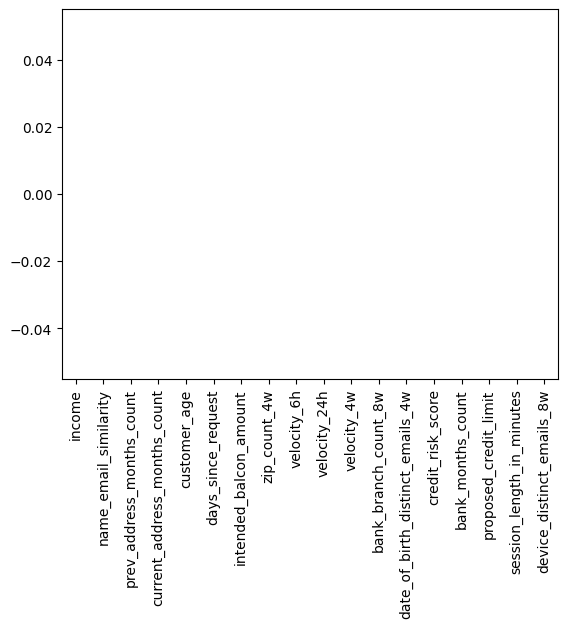

In [ ]:
#No missingness moving into the processing stage
df_cont.isna().mean().plot(kind='bar', color='thistle')

<Axes: >

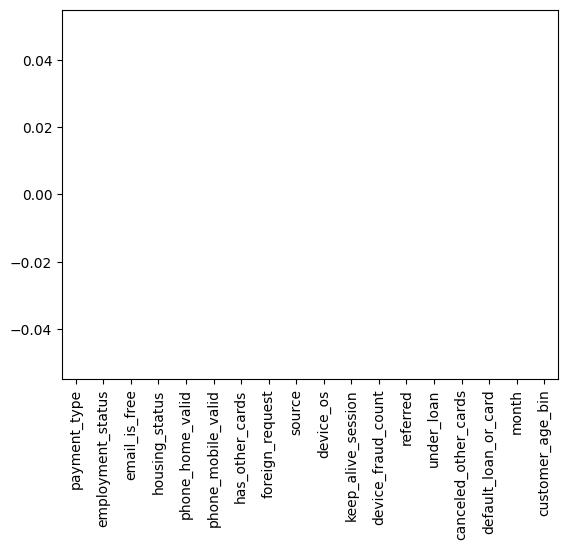

In [ ]:
#No missingness moving into the processing stage
df_cat.isna().mean().plot(kind='bar', color='thistle')

#Section 4: Feature Engineering 🧰

##Employment Status

In [ ]:
#Employment status has 7 categories- shorten to 5
df_cat["employment_status"].value_counts()

CA    73476
CB    13713
CF     4266
CC     3708
CD     2575
CE     2217
CG       45
Name: employment_status, dtype: int64

In [ ]:
#Bin employment status into 5 categories
top_5 = df_cat['employment_status'].value_counts().index[0:4]
df_cat['employment_status'] = np.where(df_cat['employment_status'].isin(top_5), df_cat['employment_status'], "other")

#Check to see if binned properly
df_cat['employment_status'].value_counts()

CA       73476
CB       13713
other     4837
CF        4266
CC        3708
Name: employment_status, dtype: int64

##Address

In [ ]:
#Check correlation between current address and velocity_24h
#Note: These are not highly correlated
df_cont['prev_address_months_count'].corr(df_cont["current_address_months_count"])

-0.2683582743255395

In [ ]:
#Note: Lots of missing values , -1 = missing
df["prev_address_months_count"].value_counts()

-1      71247
 11      1097
 29      1064
 10      1007
 27       994
        ...  
 253        1
 258        1
 363        1
 259        1
 260        1
Name: prev_address_months_count, Length: 356, dtype: int64

In [ ]:
#Note: Not a lot of missing values , -1 = missing
df["current_address_months_count"] .value_counts()

7.0      1606
8.0      1571
5.0      1556
6.0      1535
9.0      1525
         ... 
394.0       2
410.0       1
413.0       1
397.0       1
402.0       1
Name: current_address_months_count, Length: 402, dtype: int64

In [ ]:
#ASSUMPTION: More important to know if they had one or not rather than months lived there.
#ASSUMPTION: Move forward with prev_address as a bin due to lots of misisng values
#Imputation would distort true state of feature
df_cont['prev_address_bin'] = np.where(df_cont['prev_address_months_count']== -1, 0, 1)
df_cont['prev_address_bin'].value_counts()

0    71247
1    28753
Name: prev_address_bin, dtype: int64

##Velocity of Applications

In [ ]:
#Check correlation between velocity_4w and velocity_24h
df_cont['velocity_4w'].corr(df_cont['velocity_24h'])

0.5345785177738184

In [ ]:
#Check correlation between velocity_6h and velocity_24h
df_cont['velocity_6h'].corr(df_cont['velocity_24h'])

0.46167150018150416

In [ ]:
#ASSUMPTION: velocity_4w and velocity_6h are highly corralted with velocity_24
#Drop velocity_4w and velocity_6h
df_cont = df_cont.drop(['velocity_4w'], axis=1)
df_cont = df_cont.drop(['velocity_6h'], axis=1)

#Section 5: Functions ⚡

In [ ]:
#Define IQR function
def my_iqr(col):
  """outlier handling via the IQR method"""
  ### use np functions to better fit in pipeline
  iqr = 1.5 * (np.quantile(col,.75) - np.quantile(col,.25))
  u_bound = np.quantile(col,.75) + iqr
  l_bound = np.quantile(col,.25) - iqr
  col[col > u_bound], col[col < l_bound] = u_bound, l_bound
  return col

In [ ]:
outlier_handler = FunctionTransformer(my_iqr)

In [ ]:
#Define 3STD function
def my_3std(col):
  """outlier handling via the 3STD method"""
  ### use np functions to better fit in pipeline
  std_find = col.std()
  u_bound = col.mean() + (3*std_find)
  l_bound = col.mean() - (3*std_find)
  col[col > u_bound], col[col < l_bound] = u_bound, l_bound
  return col

In [ ]:
std_handler = FunctionTransformer(my_3std)

#Section 6: Pipelines 🖇

In [ ]:
# Import additional libraries
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [ ]:
#1A: Normalize, Outlier 3std, Scaling z-score
pro1a_prepoc = Pipeline([
    ('normalizer', Normalizer()),
    ('std_dev', std_handler),
    ("scaler", StandardScaler()),
])

In [ ]:
#1B: Normalize, Scaling z-score, Outlier 3std
pro1b_prepoc = Pipeline([
    ('normalizer', Normalizer()),
    ("scaler", StandardScaler()),
    ('std_dev', std_handler),
])

In [ ]:
#2A: Outlier IQR, Scaling minmax, Normalization
pro2a_prepoc = Pipeline([
    ('outlier', outlier_handler),
    ("minmax", MinMaxScaler()),
    ('normalizer', Normalizer()),
])

In [ ]:
#2B: Scaling minmax, Outlier IQR, Normalization
pro2b_prepoc = Pipeline([
    ("minmax", MinMaxScaler()),
    ('outlier', outlier_handler),
    ('normalizer', Normalizer()),
])

In [ ]:
#3A: Outlier IQR, Normalization, Scaling z-score
pro3a_prepoc = Pipeline([
    ('outlier', outlier_handler),
    ('normalizer', Normalizer()),
    ("scaler", StandardScaler()),
])

In [ ]:
#3B: Scaling minmax, Normalization, Outlier 3std
pro3b_prepoc = Pipeline([
    ("minmax", MinMaxScaler()),
    ('normalizer', Normalizer()),
    ('std_dev', std_handler),
])

In [ ]:
#Define categorical and continuous columns variables to pass into ct
cat_cols= list(df_cat.columns)
cont_cols= df_cont.columns

In [ ]:
#Use column transformer one hot encoder
ct = ColumnTransformer([
    # (name, transformer, columns)
    # Transformer for categorical variables
    ("onehot",
         OneHotEncoder(categories='auto', handle_unknown='ignore', ),
         cat_cols),
    # Transformer for continuous variables
    ("cont_preproc",pro1a_prepoc, cont_cols)
    ],
    # what to do with variables not specified in the indices?
    remainder="drop")

In [ ]:
#Define processes
processes = [pro1a_prepoc, pro1b_prepoc, pro2a_prepoc, pro2b_prepoc, pro3a_prepoc, pro3b_prepoc]

In [ ]:
#Make a list of all the processes
#Results are list of transformed data frames
results = []
for process in processes:
  ct = ColumnTransformer([
    # (name, transformer, columns)
    # Transformer for categorical variables
    ("onehot",
         OneHotEncoder(categories='auto', handle_unknown='ignore', ),
         cat_cols),
    # Transformer for continuous variables
    ("cont_preproc", process, cont_cols)
    ],
    # what to do with variables not specified in the indices?
    remainder="drop")
  cat_col_names = OneHotEncoder().fit(df_cat).get_feature_names_out(df_cat.columns)
  cont_col_names = list(df_cont.columns)
  total_df = df_cat.join(df_cont)
  X_train_transformed = ct.fit_transform(total_df)
  all_cols = list(cat_col_names) + list(cont_col_names)
  data = pd.DataFrame(X_train_transformed,columns = [all_cols])
  total_df = df_cat.join(df_cont)
  results.append(data)


In [ ]:
# Save data as a file
import pickle

with open('/content/drive/MyDrive/results.pkl', 'wb') as f:
  pickle.dump(results, f)

# note that output file is opened in binary mode 'wb' file type is .pkl and path is a file name nor a directory

In [ ]:
#Run profiling once at the beginning, comment out for efficiency
!pip3 install ydata_profiling
import ydata_profiling

ydata_profiling.ProfileReport(df)

#Section 7: Feature Selection 👉

In [ ]:
#Determine shape of dataframe with new values
array = df.values
X = total_df.values[:,0:34] #features
y = array[:,34]

In [ ]:
def feature_selector(X, y, model, names, _method="topk", n=int(X.shape[1]/2), fit_X=False, thres = 0.1):
  """voting based feature selector
  - _method: "topk" for top-K method (default), "cutoff" for cut-off based method
  - n: number of features to be selected. only available for top-K method - default half of the total features
  - thres: cut-off threshold (default 0.1), only availabel for cutoff method
  - fit_X: fit_transform X or just return indices
  TODO: include support for regression problems
  """
  #### Placeholder for tests
  # X.shape[0] == y.shape[0]
  if names: # if given feature names
    feature_names = np.array(names)
  else: # otherwise use location
    feature_names = np.array(["X%s" % x for x in range(len(X.shape[0]))])
  if _method == 'topk':
    #### np.argpartition gets the indices of the largest n element from the array in ascending order
    #### [::-1] reverse the order
    ############################################################################
    #### IMPORTANT:
    #### use `chi2` as the `score_func` when doing categorical features - values has to be non-negative
    #### use `f_classif` as the `score_func` when doing categorical and continuous feautures
    #### use `f_regression` as the `score_func` when doing continuous feautures
    ############################################################################
    corr_features = list(np.argpartition(SelectKBest(score_func=f_classif, k=n).fit(X,y).scores_, -n)[-n:][::-1])
    #### binary masking on features, use np.where() to get the indices of selected
    rfe_features = list(np.where(RFE(model, n_features_to_select=n, step=1).fit(X, y).support_)[0])
    #### argsort get sorted indices by values, ::-1] reverse the asceding order
    ridge_features = list(np.argsort(Ridge(alpha=1.0).fit(X, y).coef_)[-n:][::-1])
    #### using ExtraTree
    extratree_features = list(np.argsort(ExtraTreesClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    ### using Random Forest:
    rf_features = list(np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[-n:][::-1])
    print("Using the Top-K method: ")
    print("Selected features by correlation: ", feature_names[corr_features])
    print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])

  elif _method == 'cutoff':
    corr_features, rfe_features = list(), list() #### N/A
    ridge_features = list(np.where(Ridge(alpha=1.0).fit(X, y).coef_ > thres)[0])
    extratree_features = list(np.where(ExtraTreesClassifier().fit(X, y).feature_importances_ > thres)[0])
    rf_features = list(np.where(RandomForestClassifier().fit(X, y).feature_importances_ > thres)[0])
    print("Using the Cutoff method: ")
    # print("Selected features by correlation: ", feature_names[corr_features])
    # print("Selected features by RFE: ", feature_names[rfe_features])
    print("Selected features by Ridge coefficients: ", feature_names[ridge_features])
    print("Selected features by Extra Tree feature importance: ", feature_names[extratree_features])
    print("Selected features by Random Forest feature importance: ", feature_names[rf_features])
  else:
    return("Only Top-K and Cutoff methods are currently supported!")

  ######################################
  #### combine results using voting ####
  ######################################
  counted = Counter(np.concatenate((corr_features, rfe_features, ridge_features, extratree_features, rf_features), axis=None)).most_common(n)

  #### list of tuples (feature_index, votes)
  counted.sort(key = lambda x: x[1], reverse=True)
  final_select_series = pd.Series({feature_names[f]:c for f,c in counted}).sort_values(ascending=False)
  selected_idx = sorted([f for f,c in counted])
  assert len(selected_idx) == n
  print(final_select_series)
  if fit_X:
    return(X[:,selected_idx])
  else:
    return(feature_names[selected_idx])

In [ ]:
#Save selected features
selected_features_dict = {}
for n, X in enumerate(results):
  print(f'{n} of {len(results)} dataframes')
  ID = f'Pipeline{n}'
  print(ID)

  selected_features = feature_selector(X, df.fraud_bool, model=RandomForestClassifier(),names = all_cols)
  selected_features_dict.update({ID:selected_features})

In [ ]:
#Updated dictionary of pipelines and selected features
dict = {'Pipeline0': ['housing_status_BA', 'keep_alive_session_0.0', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
       'Pipeline1': ['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
        'Pipeline2': ['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], 'Pipeline3': ['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], dtype='<U37'), 'Pipeline4': array(['housing_status_BA', 'keep_alive_session_0.0', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
      dtype='<U37'), 'Pipeline5': array(['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], dtype='<U37')}


NameError: ignored

{'Pipeline0': array(['housing_status_BA', 'keep_alive_session_0.0', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
      dtype='<U37'), 'Pipeline1': array(['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
      dtype='<U37'), 'Pipeline2': array(['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], dtype='<U37'), 'Pipeline3': array(['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], dtype='<U37'), 'Pipeline4': array(['housing_status_BA', 'keep_alive_session_0.0', 'income',
       'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_24h',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w'],
      dtype='<U37'), 'Pipeline5': array(['housing_status_BA', 'device_os_windows', 'income',
       'name_email_similarity', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w',
       'prev_address_bin'], dtype='<U37')}

#Section 8: Modeling  🔂

Links to notebook that encompass modeling

[Combined Models](https://drive.google.com/file/d/1eFRajFWs2zJP80zWQw0O7XtFWWsuebL2/view?usp=sharing)

[Gradient Boost](https://drive.google.com/file/d/17BAmn0oFNauUy3nW37HqxKD6X6FK4Y3m/view?usp=share_link)

[Random Forest](https://drive.google.com/file/d/1_dp6YGxLF8FtUF3zsTLbLtljyBGmA335/view?usp=sharing)

[Decision Tree](https://drive.google.com/file/d/1u51GYE3GpTNM07-3ip9Kb33Cpds10VbQ/view?usp=sharing)

[Naive Model](https://drive.google.com/file/d/1E_B5DR31jzIIw-yJW3o1IRO1qsYsVYMX/view?usp=sharing)

[TPOT](https://colab.research.google.com/drive/1KsbB0q8-dg2iEze0pGQUnwrkGb9h8n-B?usp=share_link)

[Keras](https://colab.research.google.com/drive/1na28A4G0ZfEtsh89pmbTB641d6FHr5IZ?usp=share_link)

# Section 9: Conclusion 💡

**Can we detect bank application fraud?**

We believe that, yes, we can detect bank application fraud.




**Is there a model that works better than others?**

The best model results we got were from decision tree, random forest, and gradient boost. The random forest model yielded the best recall results at about .65. However, we believe this model is best used in conjunction with a decision tree. The decision tree allows the user to see the process behind the model, whereas the random forest model is simply a black box that spits out an output.



**What features help to best detect fraud?**

While we assumed features such as income, domain email, current address, age, and credit score would be the best indicators of fraudsters, this was not the case. The five most important features were housing status BA (unknown), device windows, keep alive session false, email is free true, and phone home valid false. Of the total features, the model yielded 14 important in detecting fraud.





# Section 10: Next steps:: ⏭


Because fraud detection and prevention is an ongoing process for all companies, especially those in the financial services industry, there are many steps that can be taken to develop this model and the results. One thing to be done is clearly outline who the stakeholders are and what perspective is being analyzed. This is important to do in determining what the best evaluation metric is whether that be recall or accuracy for example. An additional next step would be to optimize the data collection in general. This could be done first by evaluating the importance of each application question and ensuring that there is a purpose to each one. Some other methods for next steps include developing deep learning models such as Tensorflow.